### Batch Chorale Using RNN
#### Sequence Data 분석하기

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layer
import numpy as np

#### 1. INFO
- 바흐의 교향곡의 모든 382개의 합창곡으로 구성이 되어 있는 dataset이다.
- 각 곡은 100개에서 640개의 time step의 길이를 가지고 있으며, 각 timestep은 4개의 정수를 담고 있다.
- 각 정수는 피아노 음표의 인덱스에 해당하는데, 이번 노트북의 목표는 chorale의 time step sequence가 주어지면 다음 time step(4개의 음표)를 예측할 수 있는 
    1. 순환 모델
    2. 신겸망 모델 + 순환 모델  
        - Wave Net
        - LSTM
        - GRU
    을 만들 예정이다.
- 추가적으로 gradient 문제를 해결 할 수 있도록 Layer Normalization도 추가해 볼 예정이다.

In [2]:
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/master/datasets/jsb_chorales/"
FILENAME = "jsb_chorales.tgz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/jsb_chorales",
                                extract=True)

In [3]:
filepath

'C:\\Users\\이지혜\\.keras\\datasets/jsb_chorales\\jsb_chorales.tgz'

In [4]:
import pathlib
jsb_chorales_dir = pathlib.Path(filepath).parent
train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))
test_files = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

In [21]:
import pandas as pd

def load_chorales(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)

In [8]:
train_chorales[0][:5]

[[74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [75, 70, 58, 55]]

In [82]:
len(train_chorales), len(valid_chorales), len(test_chorales)

(229, 76, 77)

In [14]:
for i in range(5):
    print('%d ' %len(train_chorales[i]))

192 
228 
208 
432 
260 


In [6]:
notes = set()
for steps in (train_chorales, test_chorales, valid_chorales):
    for note in steps:
        for i in note:
             notes |= set(i)


In [7]:
min_note, max_note = min(notes-{0}), max(notes)

In [8]:
min_note, max_note
len_notes = len(notes)

    예측을 할때에 조금이라도 정확도를 높이기 위해서 아무 음표도 없다는 의미의 0을 제외하고 나머지 음표에 대한 최댓값과 최솟값을 구해 주었다. 따라서 나중에 훈련할 때에도 36과 81사이의 정수로 예측을 하도록 해야 한다.

#### 2. Prepare Dataset
- 우선 모든 곡에 대한 timestep의 길이가 다르기 때문에 데이터를 tf.data.Dataset으로 바꾸려 할때에 ragged tensor이라 잘 변형이 되지 않았다.
- 이렇게 입력 데이터가 4개의 음표로 나누어 있기 때문에 발생하는 현상인데, 그래서 그냥 sequence-to-sequence network를 이용하는 김에 입력 데이터로 지정해준 변수 window의 크기 만큼의 음표의 sequence를 제공해 주면 그것의 1step이후의, 똑같은 window크기 만큼 예측을 하는 것이다.
    - 즉, (3,3+window크기) 만큼 준다면 4~4+window크기 만큼의 데이터를 예측하도록 하는 방법이다.
- 그리고 모든 데이터의 크기의 범위를 0~46으로 바꿔주도록 했다.(나중의 Embedding Layer을 위해서)
- 32개의 timestep, 즉 32 * 4 = 128개의 음표를 입력값으로 주어서 예측을 하도록 하였다.
- 그리고 나중에는 tf.data.Dataset.from_tensor_slices()처리를 한 뒤에 shuffle과 batch_size를 이용해서 데이터셋을 만들었다.

```tf.data.Dataset.Window()``` 함수는 입력데이터의 window 크기만큼 묶어서 dataset의 형태로 바꾸어 준다.

In [9]:
def make_target(data):
    #x, 즉 입력 데이터는 전체 분할 데이터의 각각의 처음부터 끝의 하나 전까지, y는 각각의 두번째부터 끝까지
    x = data[:,:-1]
    y = data[:,1:]
    return x,y

#데이터의 범위를 0-46까지로 바꾸어 주기 위한 전처리용 함수
def preprocess(data):
    for i in range(len(data)):
        for j in range(len(data[i])):
            for k in range(len(data[i][j])):
                if data[i][j][k] != 0:data[i][j][k] -= 35
    return data

#데이터중에 32개의 timestep을 하나의 긴 sequence로 바꿔야 하다 보니 각각의 window묶음에 대해서 reshaping을 해주어야 했다.
#중요한 것은 이게 하나의 tensor의 형태로 바뀌었을 때에 tf.reshape를 해 줄 수가 없기 때문에(차원이 안맞음)
#window로 나눠서 적용해야 해서 map()함수를 이용했다.
def reshape(window):
    #window, 즉 timestep을 32개 묶은 데이터를 하나의 데이터로 압축한다.
    return tf.reshape(window, [-1])

def make_sequence(dataset, batch_size = 32, shuffle = None, window_size = 32, window_shift = 16, cache = True):
    def batch_window(window):
        return window.batch(window_size + 1)
    def to_window(dataset):
        dataset = tf.data.Dataset.from_tensor_slices(dataset)
        dataset = dataset.window(window_size + 1, window_shift, drop_remainder = True)
        return dataset.flat_map(batch_window)
    
    dataset = preprocess(dataset)
    dataset = tf.ragged.constant(dataset, ragged_rank = 1)
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.flat_map(to_window).map(reshape)
    dataset = dataset.cache()
    if shuffle:
        dataset = dataset.shuffle(shuffle)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(make_target)
    return dataset.prefetch(1)
    
    

In [10]:
train_data = make_sequence(train_chorales, shuffle = 1000)
train_data

<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.int32, tf.int32)>

In [11]:
test_data = make_sequence(test_chorales)
val_data = make_sequence(valid_chorales)

#### 3-1. Model 1 순환 모델
**1. Customized RNN Cell**
- 그냥 간단하게 RNN Cell의 작동 원리도 다시 공부해 볼 겸 새로운 RNN Cell을 직접 만들어 보았다.
- 시퀀스가 긴 편이다 보니까 stacked RNN이 필요할 것 같았고, 따라서 하나의 RNN layer에 (tf.keras.layers.RNN)에 3개의 만든 RNN Cell을 넣어 주었다.

In [237]:
class customRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        #새롭게 RNN Cell을 만들고자 할 때에 중요한 것은 self.state_size 를 설정해 주어야 한다는 것이다.
        #일반적으로 SimpleRNNCell은 input_size와 output_size의 unit의 개수가 동일해서 마친가지로 설정해 주었다.
        self.units = units
        self.state_size = units
        self.output_size = units
        super(customRNNCell, self).__init__(**kwargs)
    
    def build(self, input_shape):
        #새롭게 입력한 X(t)의 값에 주는 가중치의 행렬의 크기는 (입력 특성의 수, unit_size)
        self.kernel = self.add_weight(shape = (input_shape[-1], self.units),initializer = 'uniform')
        #이전 timestep의 출력값인 H(t-1)의 값에 주는 가중치의 행렬의 크기는 (unit_size, unit_size)
        self.recurrent_kernel = self.add_weight(shape = (self.units, self.units), initializer = 'uniform')
        self.built = True
    
    def call(self, inputs, states):
        #states의 차원을 보면 
        prev_outputs = states[0]
        #keras.batckend.dot을 진행하면 행렬곱이 가능하지만 그러나 사실 tf.matmul()으로 바꾸어도 결과는 동일할 것이다.
        #아래의 과정은 이전 단계에 가중치, 현재 입력 값에 가중치를 곱한 것이다.
        new_outputs = tf.keras.backend.dot(inputs, self.kernel) + tf.keras.backend.dot(prev_outputs, self.recurrent_kernel)
        return new_outputs, [new_outputs]

In [244]:
cells = [customRNNCell(units = 20), customRNNCell(units = 40)]
layer = tf.keras.layers.RNN(cells)
len_notes = len(notes)

In [245]:
model1 = tf.keras.models.Sequential()
model1.add(tf.keras.layers.Embedding(input_dim  = len_notes, output_dim = 20, input_shape = [None]))
model1.add(tf.keras.layers.RNN(cells,return_sequences = True, input_shape = [None, 1]))
model1.add(tf.keras.layers.RNN([customRNNCell(40),customRNNCell(80)], return_sequences = True))
model1.add(tf.keras.layers.Dense(len_notes, activation = 'softmax'))

In [246]:
model1.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, None, 20)          940       
_________________________________________________________________
rnn_46 (RNN)                 (None, None, 40)          3200      
_________________________________________________________________
rnn_47 (RNN)                 (None, None, 80)          12800     
_________________________________________________________________
dense_15 (Dense)             (None, None, 47)          3807      
Total params: 20,747
Trainable params: 20,747
Non-trainable params: 0
_________________________________________________________________


**이 모델이 계속해서 fit을 하면 loss함수 때문에 문제가 생겼었다. 이는 내가 마지막 dense layer을 softmax로 설정해서 출력 차원이 47개인데 mean_squared_error로 loss를 계산하려 했기 때문이다.**

In [247]:
model1.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Nadam(learning_rate = 0.002), metrics = ['accuracy'])

In [250]:
hist1 = model1.fit(train_data, validation_data = val_data, epochs = 10)

Epoch 1/10
98/98 [==============================] - 16s 158ms/step - loss: 1.6156 - accuracy: 0.5055 - val_loss: 1.5885 - val_accuracy: 0.5142
Epoch 2/10
98/98 [==============================] - 19s 192ms/step - loss: 1.4851 - accuracy: 0.5695 - val_loss: 1.4377 - val_accuracy: 0.5979
Epoch 3/10
98/98 [==============================] - 19s 198ms/step - loss: 1.4114 - accuracy: 0.6152 - val_loss: 1.4083 - val_accuracy: 0.6261
Epoch 4/10
98/98 [==============================] - 21s 214ms/step - loss: 1.3562 - accuracy: 0.6486 - val_loss: 1.3479 - val_accuracy: 0.6572
Epoch 5/10
98/98 [==============================] - 20s 202ms/step - loss: 1.3017 - accuracy: 0.6812 - val_loss: 1.2992 - val_accuracy: 0.6769
Epoch 6/10
98/98 [==============================] - 21s 214ms/step - loss: 1.2723 - accuracy: 0.6924 - val_loss: 1.3067 - val_accuracy: 0.6773
Epoch 7/10
98/98 [==============================] - 21s 214ms/step - loss: 1.2295 - accuracy: 0.7050 - val_loss: 1.2204 - val_accuracy: 0.6990

In [251]:
model1.evaluate(test_data)

     34/Unknown - 1s 30ms/step - loss: 1.1699 - accuracy: 0.7011 1s 28ms/step

[1.169853638200199, 0.70110965]

**Accuracy = 70.11%**

**2. Customizationed Layer Normalization RNN Cell**
- 우선 LSTM Layer을 첫번째 층에 사용하여서 단기 기억 소실을 방지하기 위해서 사용하였고
- 기존에 사용하는 SimpleRNNCell에 대해서 Layer Normalization과 Dropout 기능을 추가한 새로운 cell을 custom하였는데, 모든 층에서 dropout을 하기 그래서 drop_val이라는 boolean 변수를 입력 받아 True이면 타임 스텝의 모든 은닉 상태에 대해서 dropout을 진행하게 된다.

In [35]:
class LayerNormRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation = 'tanh', **kwargs):
        super(LayerNormRNNCell, self).__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.RNNCell = tf.keras.layers.SimpleRNNCell(units = units, activation = None)
        self.output_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)
    
    def call(self, input_x, states):
        new_outputs, new_states = self.RNNCell(input_x, states)
        new_outputs = self.activation(self.output_norm(new_outputs))
        return new_outputs, [new_outputs]
        

In [40]:
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Embedding(input_dim  = len_notes, output_dim = 5, input_shape = [None]))
model2.add(tf.keras.layers.RNN(LayerNormRNNCell(units = 40),
                               return_sequences = True,input_shape = [None, 1]))
model2.add(tf.keras.layers.RNN(LayerNormRNNCell(units = 40),
                               return_sequences = True))
model2.add(tf.keras.layers.Dense(47, activation = 'softmax'))

In [41]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 5)           235       
_________________________________________________________________
rnn_7 (RNN)                  (None, None, 40)          1920      
_________________________________________________________________
rnn_8 (RNN)                  (None, None, 40)          3320      
_________________________________________________________________
dense_4 (Dense)              (None, None, 47)          1927      
Total params: 7,402
Trainable params: 7,402
Non-trainable params: 0
_________________________________________________________________


In [42]:
model2.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Nadam(learning_rate = 0.002), metrics = ['accuracy'])
hist2 = model2.fit(train_data, validation_data = val_data, epochs = 10)

Epoch 1/10
98/98 [==============================] - 28s 284ms/step - loss: 3.4851 - accuracy: 0.0691 - val_loss: 3.3959 - val_accuracy: 0.0743
Epoch 2/10
98/98 [==============================] - 27s 272ms/step - loss: 3.3489 - accuracy: 0.0868 - val_loss: 3.3269 - val_accuracy: 0.0986
Epoch 3/10
98/98 [==============================] - 27s 273ms/step - loss: 2.9329 - accuracy: 0.1407 - val_loss: 2.6742 - val_accuracy: 0.1422
Epoch 4/10
98/98 [==============================] - 27s 273ms/step - loss: 2.5909 - accuracy: 0.1695 - val_loss: 2.6065 - val_accuracy: 0.1644
Epoch 5/10
98/98 [==============================] - 27s 274ms/step - loss: 2.5650 - accuracy: 0.1764 - val_loss: 2.5862 - val_accuracy: 0.1742
Epoch 6/10
98/98 [==============================] - 27s 274ms/step - loss: 2.5445 - accuracy: 0.1812 - val_loss: 2.5557 - val_accuracy: 0.1632
Epoch 7/10
98/98 [==============================] - 27s 274ms/step - loss: 2.5140 - accuracy: 0.1925 - val_loss: 2.5302 - val_accuracy: 0.1823

In [43]:
model2.evaluate(test_data)

     34/Unknown - 2s 53ms/step - loss: 2.2809 - accuracy: 0.2765

[2.2808691894306854, 0.27647611]

**Accuracy - 6.97%**
- 정확도가 터무니 없이 낮은데 아마 dropout을 추가해 줬기 때문 인것 같다.
- 원래 Layer Normalization에 각 timestep마다 은닉층의 값에 dropout을 하는 방법으로 RNN cell을 만들었었는데, 그렇게 하니까 필요한 데이터가 다 dropout되는 듯 했다. 
- 그래서 그 부분을 빼고 오직 Layer Normalization의 기능만 추가해 주었으며, Embedding layer이후에 추가해 주었었던 LSTM layer또한 빼버렸다.  

**New Accuracy = 27.65%**
- 계속 학습을 시키면 더 정확도가 올라가겠지만 일단은 계속 정확도가 상승곡선이고 손실이 감소하기 때문에 만족스럽다.


#### 3-2. Model 2- 합성곱 + 순환

#### 3. Conv Layer + Recurrent Layer
- 지금까지의 결과가 안좋았던 이유는 여러개가 있겠지만 무엇보다도 **Embedding Layer**을 추가해 주지 않았기 때문이 클 것이라고 생각한다.
- 악보 또한 문자나 언어나 음성 등 처럼 일정한 연관성이 서로 있는데 그 부분을 고려해 주지 않으면 제대로 학습이 될 리가 없기 때문이다.
- 따라서 처음에 Embeddding Layer을 추가해 주었고, Conv1D layer을 이용해서 학습을 해주다가 마지막에 LSTM과 Dense layer을 넣어 주었다.

1. 악상간의 연관성을 따져주기 위해서 Embedding layer을 추가했고, Embedding layer의 input_dim은 총 사용된 음표의 종류의 개수이고, output_dim은 그냥 임의로 설정해 준 값이다. 이는 하나의 음표를 몇 차원으로 바꾸어 줄 것인지 설정한다.
    - Embedding Layer은 모든 입력 데이터를 각각의 다른 벡터로 바꾸어 주는데, 이경우는 각각을 5차원 벡터로 바꾼 것이다.
2. 이후에는 간단한 Wave Net을 구현하였다.
3. 그리고 마지막에는 긴 장기 기억을 위해서 LSTM layer을 추가 하였다.
4. 최종 Dense layer은 47개의 unit을 이용해서 출력을 하는데, 이유는 다음에 바로 나올 하나의 악상을 예측하는 것이며, 이를 47개중 하나로 출력하게 될 것이다.

In [12]:
n_embedding_dims = 5

model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=len_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
    keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.Dense(len_notes, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 5)           235       
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          352       
_________________________________________________________________
batch_normalization (BatchNo (None, None, 32)          128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 48)          3120      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 48)          192       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          6208      
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 64)          2

In [13]:
optimizer = tf.keras.optimizers.Nadam(learning_rate = 0.002)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [15]:
hist3 = model.fit(train_data, validation_data = val_data, epochs = 20)

Epoch 1/20
98/98 [==============================] - 7s 72ms/step - loss: 1.4455 - accuracy: 0.6312 - val_loss: 3.6789 - val_accuracy: 0.0780
Epoch 2/20
98/98 [==============================] - 15s 158ms/step - loss: 0.7478 - accuracy: 0.7920 - val_loss: 4.0066 - val_accuracy: 0.1207
Epoch 3/20
98/98 [==============================] - 23s 233ms/step - loss: 0.6314 - accuracy: 0.8153 - val_loss: 3.5202 - val_accuracy: 0.1594
Epoch 4/20
98/98 [==============================] - 23s 232ms/step - loss: 0.5537 - accuracy: 0.8331 - val_loss: 2.9299 - val_accuracy: 0.2739
Epoch 5/20
98/98 [==============================] - 23s 231ms/step - loss: 0.5001 - accuracy: 0.8463 - val_loss: 2.1968 - val_accuracy: 0.4148
Epoch 6/20
98/98 [==============================] - 23s 231ms/step - loss: 0.4560 - accuracy: 0.8581 - val_loss: 0.7203 - val_accuracy: 0.7911
Epoch 7/20
98/98 [==============================] - 23s 232ms/step - loss: 0.4205 - accuracy: 0.8686 - val_loss: 0.6388 - val_accuracy: 0.8086
E

In [16]:
model.evaluate(test_data)

     34/Unknown - 1s 32ms/step - loss: 0.7045 - accuracy: 0.8156

[0.7044693073805641, 0.8156349]

**Accuracy = 81.56%**

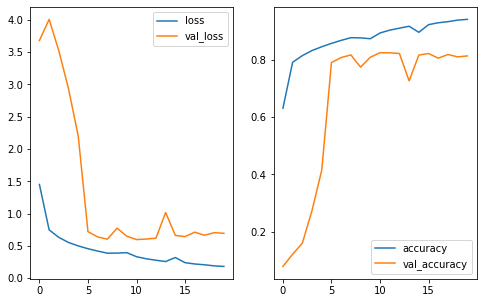

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,5))
plt.subplot(1,2,1)
plt.plot(hist3.history['loss'], label = 'loss')
plt.plot(hist3.history['val_loss'], label = 'val_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist3.history['accuracy'], label = 'accuracy')
plt.plot(hist3.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

In [25]:
def make_chorale(model, seed_chord, length):
    sound = tf.constant(seed_chord, dtype = tf.int64)
    sound = tf.where(sound == 0, sound, sound - 35)
    sound = tf.reshape(sound, [1,-1])
    for i in range(length):
        for j in range(4):
            next_predict = model.predict_classes(sound)[:1, -1:]
            sound = tf.concat([sound,next_predict], axis = 1)
    sound = tf.where(sound == 0, sound, sound + 35)
    return tf.reshape(sound, shape = [-1,4])